In [1]:
modelName = 'dpn98'
filterName = 'normalize'

point = 'Point1'

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        
        self.device = device
        
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration

        img = read_image(self.df.loc[idx, 'img_path'])[:3,:,:]
        filename = self.df.loc[idx, 'filename']
        sign = self.df.loc[idx, 'sign']
        
        if self.transform:
            img = self.transform(img)

        return img, filename, sign
    
    def getData(self):
        return list(self)

In [7]:
def createDataFrame():
    
    train_df = pd.read_csv('../../data/train.csv')
    train_df['img_path'] = '../../data/avia-train/avia-train/' + train_df['filename'] + '.png'
    
    test_df = pd.read_csv('../../data/test.csv')
    test_df['img_path'] = '../../data/avia-test/avia-test/' + test_df['filename'] + '.png'
    test_df['sign'] = -1
    
    test_e_df = pd.read_csv('../../data/test_extended.csv', index_col='filename')
    
    test_e_df = test_e_df.drop(test_df['filename'])
    test_e_df['filename'] = test_e_df.index
    
    test_e_df['img_path'] = '../../data/avia-test-extended/avia-test-extended/' + test_e_df['filename'] + '.jpeg'
    test_e_df['sign'] = -1
    
    df = pd.concat((train_df, test_df, test_e_df)).reset_index(drop=True)
    
    df['sign'] = df['sign'].astype('float64')
    
    return df

In [8]:
def createDataLoader(df, batch_size=None, shuffle=False, transform=None):

    batch_size = batch_size if batch_size else len(df)
    
    dataset = CustomImageDataset(df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataset, dataloader

In [9]:
df = createDataFrame()

In [10]:
model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn98', pretrained=True)
    
model.classifier = torch.nn.Sequential(
    nn.Conv2d(model.classifier.in_channels, 1, kernel_size=(1, 1), stride=(1, 1)),
    nn.Sigmoid()
)

weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using cache found in C:\Users\User/.cache\torch\hub\rwightman_pytorch-dpn-pretrained_master


In [11]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 15
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=250, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=40, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device).float().reshape(-1, 1)
            
            y_predict = model(X)

            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}_{point}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 15 | Train loss: 0.02193411385291256 | Val loss: 0.008419249466477105
Epoch: 2 / 15 | Train loss: 0.007166336019290611 | Val loss: 0.005155900201479642
Epoch: 3 / 15 | Train loss: 0.0053248530183918775 | Val loss: 0.004175356079101151
Epoch: 4 / 15 | Train loss: 0.0035881584021262825 | Val loss: 0.004320107113390128
Epoch: 5 / 15 | Train loss: 0.003153068125830032 | Val loss: 0.003768736229922536
Epoch: 6 / 15 | Train loss: 0.002615646001941059 | Val loss: 0.0038927004721839554
Epoch: 7 / 15 | Train loss: 0.001906007737852633 | Val loss: 0.004838815051698475
Epoch: 8 / 15 | Train loss: 0.0019243129999085796 | Val loss: 0.003985028909739459
Epoch: 9 / 15 | Train loss: 0.0016577501220308476 | Val loss: 0.004044721187489277
Epoch: 10 / 15 | Train loss: 0.0019468014011363266 | Val loss: 0.003349587925932167
Epoch: 11 / 15 | Train loss: 0.0012962176565633854 | Val loss: 0.0032158148842660384
Epoch: 12 / 15 | Train loss: 0.002090061336057261 | Val loss: 0.0029396166590767957
Epoch

11


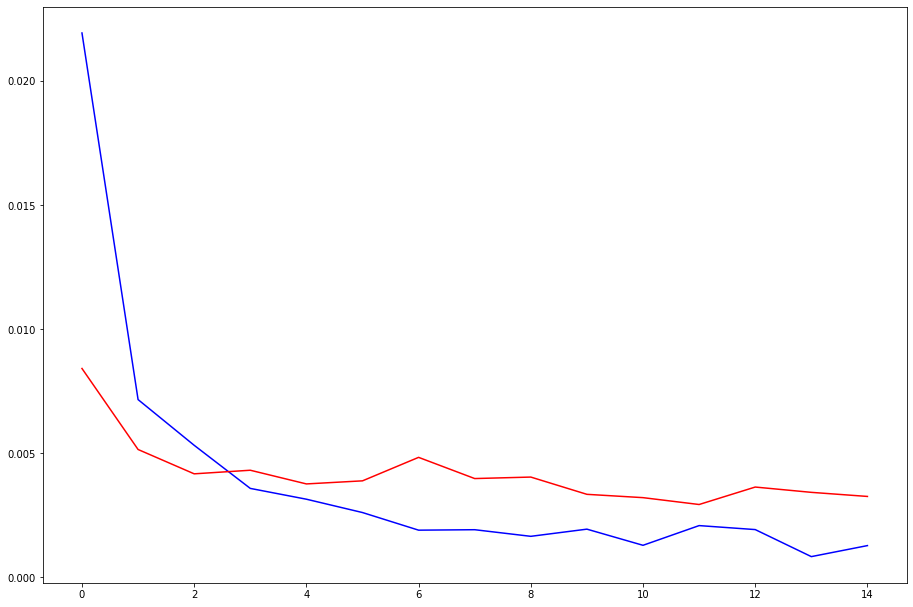

In [12]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [13]:
model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn98', pretrained=True)
    
model.classifier = torch.nn.Sequential(
    nn.Conv2d(model.classifier.in_channels, 1, kernel_size=(1, 1), stride=(1, 1)),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{point}.pt'))

Using cache found in C:\Users\User/.cache\torch\hub\rwightman_pytorch-dpn-pretrained_master


<All keys matched successfully>

In [14]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=40, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 12min 27s


In [15]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [16]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)
predict_df

filename  model     filter   point  v  \
0       927e57c5-2211-4c6f-9c76-f4dcbba23f7a  dpn98  normalize  Point1  0   
1       d70f6e78-2feb-48be-af8e-30d8a03bb045  dpn98  normalize  Point1  0   
2       9555d582-45aa-4cc3-826f-5c0a25160a77  dpn98  normalize  Point1  0   
3       0279bf56-5dac-42bd-b3c6-713e5818f2e7  dpn98  normalize  Point1  0   
4       0f71add3-9461-417c-8d3c-c517d87867cc  dpn98  normalize  Point1  0   
...                                      ...    ...        ...     ... ..   
528315  d290c23d-045e-43f3-9d6a-a6b8979f5342  dpn98  normalize  Point1  3   
528316  9c423183-acf3-447d-a10f-c4310dec0d5c  dpn98  normalize  Point1  3   
528317  720fbda9-9172-47ef-bd68-ed4061c7a9b6  dpn98  normalize  Point1  3   
528318  902f0786-e552-4631-9e7d-46521feb3f8c  dpn98  normalize  Point1  3   
528319  46099d00-6f6b-491d-ae59-5f461c620f6c  dpn98  normalize  Point1  3   

         predict  sign  
0       0.000067  -1.0  
1       0.000063  -1.0  
2       0.000083  -1.0  
3       0.000071  -1.0  
4       0.000063  -1.0  
...          ...   ...  
528315  0.000062  -1.0  
528316  0.000356   0.0  
528317  0.000034   0.0  
528318  0.000069  -1.0  
528319  0.000071   0.0  

[528320 rows x 7 columns]

In [17]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}_{point}.csv', index=False)

In [18]:
modelName = 'dpn98'
filterName = 'normalize'
point = 'Point2'

pointLoad = 'Point1'

In [19]:
model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn98', pretrained=True)
    
model.classifier = torch.nn.Sequential(
    nn.Conv2d(model.classifier.in_channels, 1, kernel_size=(1, 1), stride=(1, 1)),
    nn.Sigmoid()
)

weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.000001)

Using cache found in C:\Users\User/.cache\torch\hub\rwightman_pytorch-dpn-pretrained_master


In [20]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 15
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=250, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=40, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device).float().reshape(-1, 1)
            
            y_predict = model(X)

            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}_{point}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 15 | Train loss: 0.13947744891047478 | Val loss: 0.13362361786839289
Epoch: 2 / 15 | Train loss: 0.11383091360330581 | Val loss: 0.09855432617358673
Epoch: 3 / 15 | Train loss: 0.0671583205461502 | Val loss: 0.058126270078504697
Epoch: 4 / 15 | Train loss: 0.031324910577386615 | Val loss: 0.024452657683585316
Epoch: 5 / 15 | Train loss: 0.021570367040112615 | Val loss: 0.016273667961239625
Epoch: 6 / 15 | Train loss: 0.017303340965881944 | Val loss: 0.01360699409344353
Epoch: 7 / 15 | Train loss: 0.015459994310513139 | Val loss: 0.01196338950495164
Epoch: 8 / 15 | Train loss: 0.013346295016817748 | Val loss: 0.010881946516187431
Epoch: 9 / 15 | Train loss: 0.011318467613309622 | Val loss: 0.009814020198507186
Epoch: 10 / 15 | Train loss: 0.010405969661660493 | Val loss: 0.009125949264927886
Epoch: 11 / 15 | Train loss: 0.009495778329437599 | Val loss: 0.008490505908878569
Epoch: 12 / 15 | Train loss: 0.0091051191277802 | Val loss: 0.008136909629310815
Epoch: 13 / 15 | Train 

14


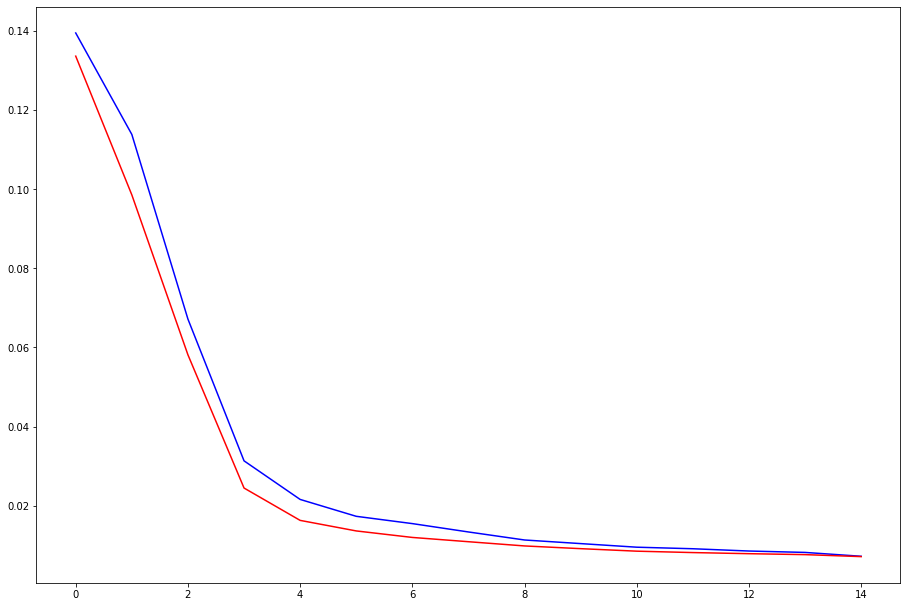

In [21]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [22]:
model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn98', pretrained=True)
    
model.classifier = torch.nn.Sequential(
    nn.Conv2d(model.classifier.in_channels, 1, kernel_size=(1, 1), stride=(1, 1)),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{point}.pt'))

Using cache found in C:\Users\User/.cache\torch\hub\rwightman_pytorch-dpn-pretrained_master


<All keys matched successfully>

In [23]:
%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=40, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 0 ns


In [24]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [25]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)
predict_df

filename  model     filter   point  v  \
0       ad75bcc3-739f-475a-8f31-5e10804e30a0  dpn98  normalize  Point2  0   
1       0c0388b5-862f-4df7-9749-462a14a7d819  dpn98  normalize  Point2  0   
2       82c26048-5dc1-413d-9768-4edb7466b752  dpn98  normalize  Point2  0   
3       ca20aafd-f29e-4c5e-a14e-458e731cb132  dpn98  normalize  Point2  0   
4       a48e9ddc-af1c-47c9-b139-d86df3e5caa4  dpn98  normalize  Point2  0   
...                                      ...    ...        ...     ... ..   
528315  9dd4bb97-2bab-48fb-90b2-a98cf6888a93  dpn98  normalize  Point2  3   
528316  65319645-07a6-49c2-bca3-db9f5e028794  dpn98  normalize  Point2  3   
528317  b2aedfb0-062a-4153-899b-681483ed6cd2  dpn98  normalize  Point2  3   
528318  4ff463f5-f253-4356-bd6f-21e9268fe095  dpn98  normalize  Point2  3   
528319  30422325-228c-4827-b4e2-a5b6550ccbf1  dpn98  normalize  Point2  3   

         predict  sign  
0       0.001819  -1.0  
1       0.004301   0.0  
2       0.002192  -1.0  
3       0.001743  -1.0  
4       0.001725  -1.0  
...          ...   ...  
528315  0.001711  -1.0  
528316  0.001702  -1.0  
528317  0.003802   0.0  
528318  0.001817  -1.0  
528319  0.001857  -1.0  

[528320 rows x 7 columns]

In [26]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}_{point}.csv', index=False)